In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings("ignore")

import nltk
import re
import string
from collections import Counter
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
print(pd.__version__)

2.1.4


In [47]:
df = pd.read_csv('/content/train.csv', engine='python', on_bad_lines='skip', quotechar='"')


In [4]:
df.head()

,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID,PRODUCT_LENGTH
0,1925202,ArtzFolio Tulip Flowers Blackout Curtain for D...,[LUXURIOUS & APPEALING: Beautiful custom-made ...,NaN,1650,2125.980000
1,2673191,Marks & Spencer Girls' Pyjama Sets T86_2561C_N...,"[Harry Potter Hedwig Pyjamas (6-16 Yrs),100% c...",NaN,2755,393.700000
2,2765088,PRIKNIK Horn Red Electric Air Horn Compressor ...,"[Loud Dual Tone Trumpet Horn, Compatible With ...","Specifications: Color: Red, Material: Aluminiu...",7537,748.031495
3,1594019,ALISHAH Women's Cotton Ankle Length Leggings C...,[Made By 95%cotton and 5% Lycra which gives yo...,AISHAH Women's Lycra Cotton Ankel Leggings. Br...,2996,787.401574
4,283658,The United Empire Loyalists: A Chronicle of th...,NaN,NaN,6112,598.424000


In [48]:
df.shape

(30004, 6)

In [6]:
df['BULLET_POINTS'].iloc[0]

'[LUXURIOUS & APPEALING: Beautiful custom-made curtains to decorate any home or office | Includes inbuilt tieback to hold the curtain | Completely finished and ready to hang on walls & windows,MATERIAL: Luxurious & versatile fabric with a natural finish | High colour fastness | State-of-the-art digital printing ensures colour consistency and prevents any fading | Eyelets; Cotton Canvas; Width 4.5feet (54inch) | Multicolour | PACKAGE: 2 Room Curtains Eyelets | SIZE: Height 5 feet (60 inch); SET OF 2 PCS,BLACKOUT CURTAIN: 100% opaque & heavy premium cotton canvas fabric | Tight knitted, long life & durable fabric | Printing only on front side with a plain colour back side,MADE TO PERFECTION: Large eyelets at the top to put hanging hooks | Perfectly tailored seams for durability | Refined stitching with a matching thread color,QUALITY ASSURED: Gentle wash with similar colors in cold water | Avoid direct sunlight to prevent fading | Dispatched after MULTIPLE QUALITY CHECKS]'

In [7]:
df["PRODUCT_ID"].nunique()

12913

In [8]:
df.shape

(12913, 6)

In [9]:
## We can make PRODUCT_ID as index
df.set_index('PRODUCT_ID', inplace=True)

In [10]:
df.index
## we updated the indexes of dataframe

Index([1925202, 2673191, 2765088, 1594019,  283658, 2152929,  413758, 2026580,
       2050239, 2998633,
       ...
       2244623,  511348, 2526573,  880624,  464900,  541846, 2941165,  647581,
       1766757,  411978],
      dtype='int64', name='PRODUCT_ID', length=12913)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12913 entries, 1925202 to 411978
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TITLE            12913 non-null  object 
 1   BULLET_POINTS    8092 non-null   object 
 2   DESCRIPTION      6211 non-null   object 
 3   PRODUCT_TYPE_ID  12913 non-null  int64  
 4   PRODUCT_LENGTH   12913 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 605.3+ KB


In [12]:
def df_information(data):
  shape         = data.shape
  info          = data.info()
  describe      = data.describe()
  column_name   = data.columns
  null_values   = data.isnull().sum()

  return shape, info, describe, column_name, null_values

In [13]:
df.isna().sum()

,0
TITLE,0
BULLET_POINTS,4821
DESCRIPTION,6702
PRODUCT_TYPE_ID,0
PRODUCT_LENGTH,0


In [14]:
## Joining the columns which are the inputs
new_df = df.copy()
# need to fill the nan values else it gonna give error
new_df["inputs"] = df[["TITLE", "BULLET_POINTS", "DESCRIPTION"]].fillna(" ").apply(lambda x: ' '.join(x), axis=1)

In [15]:
new_df.head()

,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID,PRODUCT_LENGTH,inputs
PRODUCT_ID,,,,,,
1925202,ArtzFolio Tulip Flowers Blackout Curtain for D...,[LUXURIOUS & APPEALING: Beautiful custom-made ...,NaN,1650,2125.980000,ArtzFolio Tulip Flowers Blackout Curtain for D...
2673191,Marks & Spencer Girls' Pyjama Sets T86_2561C_N...,"[Harry Potter Hedwig Pyjamas (6-16 Yrs),100% c...",NaN,2755,393.700000,Marks & Spencer Girls' Pyjama Sets T86_2561C_N...
2765088,PRIKNIK Horn Red Electric Air Horn Compressor ...,"[Loud Dual Tone Trumpet Horn, Compatible With ...","Specifications: Color: Red, Material: Aluminiu...",7537,748.031495,PRIKNIK Horn Red Electric Air Horn Compressor ...
1594019,ALISHAH Women's Cotton Ankle Length Leggings C...,[Made By 95%cotton and 5% Lycra which gives yo...,AISHAH Women's Lycra Cotton Ankel Leggings. Br...,2996,787.401574,ALISHAH Women's Cotton Ankle Length Leggings C...
283658,The United Empire Loyalists: A Chronicle of th...,NaN,NaN,6112,598.424000,The United Empire Loyalists: A Chronicle of th...


In [16]:
new_df = new_df.drop(["TITLE", "BULLET_POINTS", "DESCRIPTION", "PRODUCT_TYPE_ID"], axis=1)

In [17]:
new_df.head()

,PRODUCT_LENGTH,inputs
PRODUCT_ID,,
1925202,2125.980000,ArtzFolio Tulip Flowers Blackout Curtain for D...
2673191,393.700000,Marks & Spencer Girls' Pyjama Sets T86_2561C_N...
2765088,748.031495,PRIKNIK Horn Red Electric Air Horn Compressor ...
1594019,787.401574,ALISHAH Women's Cotton Ankle Length Leggings C...
283658,598.424000,The United Empire Loyalists: A Chronicle of th...


In [18]:
new_df.dropna(axis=0, inplace=True)

In [19]:
new_df.isna().sum()

,0
PRODUCT_LENGTH,0
inputs,0


In [20]:
new_df.shape

(12913, 2)

In [21]:
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [22]:
def remove_emojis_and_symbols(text):
    # This regex targets most emojis, hearts, and various symbols
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        u"\U0001F680-\U0001F6FF"  # Transport & Map symbols
        u"\U0001F1E0-\U0001F1FF"  # Flags (iOS)
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251"  # Enclosed characters
        u"\U00002600-\U000026FF"  # Miscellaneous Symbols (includes hearts)
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "]+", flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

In [23]:
# will start preprocessing the inputs
def preprocessing(data):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))

    def clean_sentence(sentence):
        # Convert to lowercase
        sentence = sentence.lower()

        # Remove non-alphanumeric characters
        sentence = re.sub("[^a-z0-9]", " ", sentence)

        # Remove URLs
        sentence = re.sub(r'(http|https|ftp|ssh)://[\w_-]+(?:\.[\w_-]+)+[\w.,@?^=%&/~+#-]*[\w@?^=%&/~+#-]?', '', sentence)

        # removing emojis and other symobls that are not cleaned
        sentence = remove_emojis_and_symbols(sentence)

        # Remove stopwords
        sentence = " ".join([word for word in sentence.split() if word not in stop_words])

        # Clean any potential HTML tags
        sentence = BeautifulSoup(sentence, "lxml").get_text()

        # Lemmatize words
        sentence = " ".join([lemmatizer.lemmatize(word) for word in sentence.split()])

        return sentence

    # Apply the cleaning function to each row
    data['inputs'] = data['inputs'].apply(clean_sentence)

    return data

In [24]:
cleaned_df     = preprocessing(new_df)

In [25]:
cleaned_df.head()

,PRODUCT_LENGTH,inputs
PRODUCT_ID,,
1925202,2125.980000,artzfolio tulip flower blackout curtain door w...
2673191,393.700000,mark spencer girl pyjama set t86 2561c navy mi...
2765088,748.031495,priknik horn red electric air horn compressor ...
1594019,787.401574,alishah woman cotton ankle length legging comb...
283658,598.424000,united empire loyalist chronicle great migration


In [26]:
cleaned_df.shape

(12913, 2)

In [27]:
def vocabulary(df):
    words = [word for sentence in df.inputs for word in sentence.split()]
    word_counts = Counter(words)
    unique_words = set(word_counts)
    sorted_words = word_counts.most_common()

    return sorted_words, unique_words

In [28]:
word_counts, unique_words = vocabulary(cleaned_df)

In [29]:
word_counts

[('br', 17496),
 ('p', 13629),
 ('b', 8599),
 ('size', 6585),
 ('1', 6582),
 ('quality', 5636),
 ('design', 5573),
 ('cover', 5472),
 ('material', 5224),
 ('made', 5167),
 ('case', 5050),
 ('color', 4837),
 ('easy', 4786),
 ('x', 4767),
 ('2', 4733),
 ('product', 4560),
 ('high', 4408),
 ('woman', 4167),
 ('inch', 4131),
 ('5', 4098),
 ('3', 4063),
 ('use', 4041),
 ('fit', 3819),
 ('li', 3641),
 ('perfect', 3525),
 ('gift', 3303),
 ('strong', 3218),
 ('make', 3213),
 ('4', 3154),
 ('soft', 3125),
 ('back', 3013),
 ('fabric', 2901),
 ('phone', 2880),
 ('style', 2601),
 ('look', 2594),
 ('home', 2556),
 ('set', 2455),
 ('light', 2446),
 ('durable', 2390),
 ('100', 2379),
 ('cotton', 2352),
 ('one', 2329),
 ('long', 2316),
 ('wear', 2286),
 ('water', 2261),
 ('6', 2260),
 ('black', 2237),
 ('please', 2223),
 ('length', 2218),
 ('feature', 2182),
 ('hand', 2142),
 ('protection', 2139),
 ('day', 2131),
 ('printed', 2118),
 ('free', 2075),
 ('room', 2061),
 ('8', 2036),
 ('comfortable', 1996

In [30]:
len(unique_words)

44941

In [31]:
words = []
for i, (w, c) in enumerate(word_counts):
  if c < 5:
    words.append(w)

In [32]:
len(words)

32926

In [33]:
def remove_rare_wors(word_counts):
  word_list = []
  for i, (word, cout) in enumerate(word_counts):
      if word.isdigit():
        continue
      elif cout > 5:
        word_list.append(word)

  return word_list

In [34]:
clenaed_vocabulary_   = remove_rare_wors(word_counts)

In [35]:
type(45)

int

In [36]:
len(clenaed_vocabulary_)

10359

In [37]:
clenaed_vocabulary_

['br',
 'p',
 'b',
 'size',
 'quality',
 'design',
 'cover',
 'material',
 'made',
 'case',
 'color',
 'easy',
 'x',
 'product',
 'high',
 'woman',
 'inch',
 'use',
 'fit',
 'li',
 'perfect',
 'gift',
 'strong',
 'make',
 'soft',
 'back',
 'fabric',
 'phone',
 'style',
 'look',
 'home',
 'set',
 'light',
 'durable',
 'cotton',
 'one',
 'long',
 'wear',
 'water',
 'black',
 'please',
 'length',
 'feature',
 'hand',
 'protection',
 'day',
 'printed',
 'free',
 'room',
 'comfortable',
 'also',
 'wall',
 'best',
 'nbsp',
 'great',
 'u',
 'men',
 'type',
 'used',
 'top',
 'car',
 'wash',
 'designed',
 'keep',
 'time',
 'package',
 'sleeve',
 'dress',
 'premium',
 'print',
 'dry',
 'side',
 'new',
 'give',
 'comfort',
 'party',
 'leather',
 'screen',
 'resistant',
 'piece',
 'clean',
 'shirt',
 'item',
 'suitable',
 'pack',
 'scratch',
 'shoe',
 'bag',
 'come',
 'good',
 'white',
 'glass',
 'casual',
 'full',
 'cm',
 'skin',
 'plastic',
 'weight',
 'kid',
 'stylish',
 'machine',
 'pocket',
 

In [38]:
def word_to_int(clenaed_vocabulary_):
  word_to_numeric = {}
  for i, word in enumerate(clenaed_vocabulary_):
    word_to_numeric[word] = i + 1

  return word_to_numeric

In [39]:
word_to_numeric   = word_to_int(clenaed_vocabulary_)

In [40]:
word_to_numeric

{'br': 1,
 'p': 2,
 'b': 3,
 'size': 4,
 'quality': 5,
 'design': 6,
 'cover': 7,
 'material': 8,
 'made': 9,
 'case': 10,
 'color': 11,
 'easy': 12,
 'x': 13,
 'product': 14,
 'high': 15,
 'woman': 16,
 'inch': 17,
 'use': 18,
 'fit': 19,
 'li': 20,
 'perfect': 21,
 'gift': 22,
 'strong': 23,
 'make': 24,
 'soft': 25,
 'back': 26,
 'fabric': 27,
 'phone': 28,
 'style': 29,
 'look': 30,
 'home': 31,
 'set': 32,
 'light': 33,
 'durable': 34,
 'cotton': 35,
 'one': 36,
 'long': 37,
 'wear': 38,
 'water': 39,
 'black': 40,
 'please': 41,
 'length': 42,
 'feature': 43,
 'hand': 44,
 'protection': 45,
 'day': 46,
 'printed': 47,
 'free': 48,
 'room': 49,
 'comfortable': 50,
 'also': 51,
 'wall': 52,
 'best': 53,
 'nbsp': 54,
 'great': 55,
 'u': 56,
 'men': 57,
 'type': 58,
 'used': 59,
 'top': 60,
 'car': 61,
 'wash': 62,
 'designed': 63,
 'keep': 64,
 'time': 65,
 'package': 66,
 'sleeve': 67,
 'dress': 68,
 'premium': 69,
 'print': 70,
 'dry': 71,
 'side': 72,
 'new': 73,
 'give': 74,
 'c

In [41]:
def sentence_to_int(data):
  data["inputs"] = data["inputs"].apply(lambda x: [word_to_numeric[word] for word in x.split() if word in clenaed_vocabulary_])

  return data

In [42]:
cleaned_df_to_numeric = sentence_to_int(cleaned_df)

In [43]:
cleaned_df_to_numeric["length"] = cleaned_df_to_numeric["inputs"].apply(lambda x: len(x))

In [44]:
cleaned_df_to_numeric.head()

,PRODUCT_LENGTH,inputs,length
PRODUCT_ID,,,
1925202,2125.980000,"[5123, 5742, 338, 1327, 219, 202, 329, 49, 253...",129
2673191,393.700000,"[1275, 7040, 106, 2196, 32, 752, 1130, 6308, 7...",16
2765088,748.031495,"[2235, 185, 1027, 198, 2235, 4751, 457, 632, 1...",83
1594019,787.401574,"[16, 35, 912, 42, 760, 639, 305, 11, 183, 9, 3...",113
283658,598.424000,"[1677, 4501, 6645, 55, 8580]",5


In [45]:
cleaned_df_to_numeric.describe()

,PRODUCT_LENGTH,length
count,1.291300e+04,12913.000000
mean,1.610806e+03,76.069387
std,3.581548e+04,90.042495
min,1.000000e+00,0.000000
25%,5.080000e+02,6.000000
50%,6.500000e+02,41.000000
75%,1.023622e+03,115.000000
max,3.996600e+06,633.000000


In [46]:
cleaned_df_to_numeric.shape

(12913, 3)

In [52]:
def boxplot(data):
  plt.figure(figsize=(14, 6))
  sns.boxplot(data)
  plt.show()

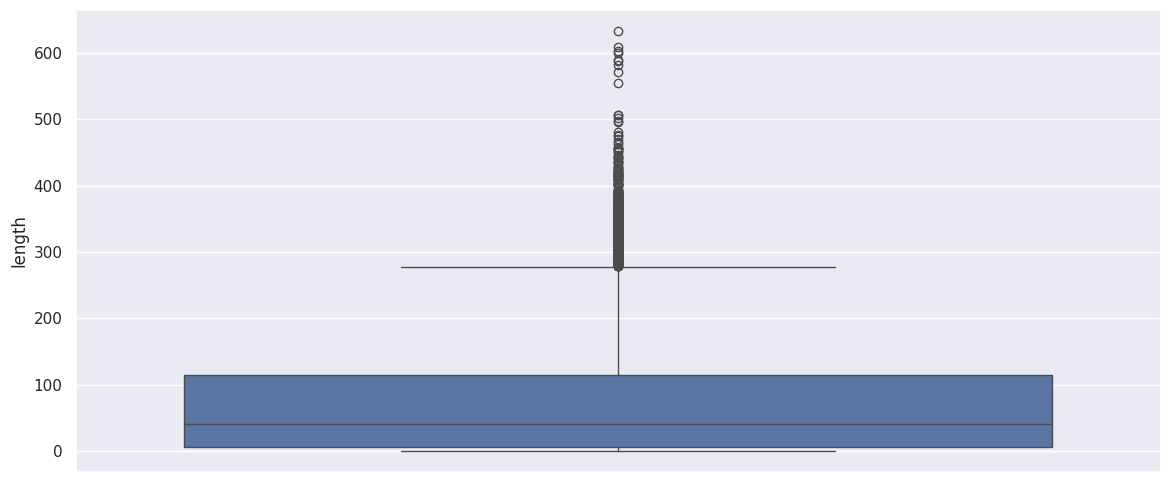

In [53]:
boxplot(cleaned_df_to_numeric["length"])

In [57]:
len(cleaned_df_to_numeric[cleaned_df_to_numeric["length"] >= 280])

564

In [59]:
len(cleaned_df_to_numeric[cleaned_df_to_numeric["length"] <= 6])

3258

In [68]:
len(cleaned_df_to_numeric[cleaned_df_to_numeric["length"] == 0 ])

235

In [60]:
## remvoing the rows from the dataset where

def remove_outliers(data, col):

  Q1      = data[col].quantile(0.25)
  Q3      = data[col].quantile(0.75)
  IQR     = Q3 - Q1

  lower_bound = Q1 -1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound) & data[col] == 0]

  return data


In [61]:
cleaned_numeric_data   = remove_outliers(cleaned_df_to_numeric, "length")

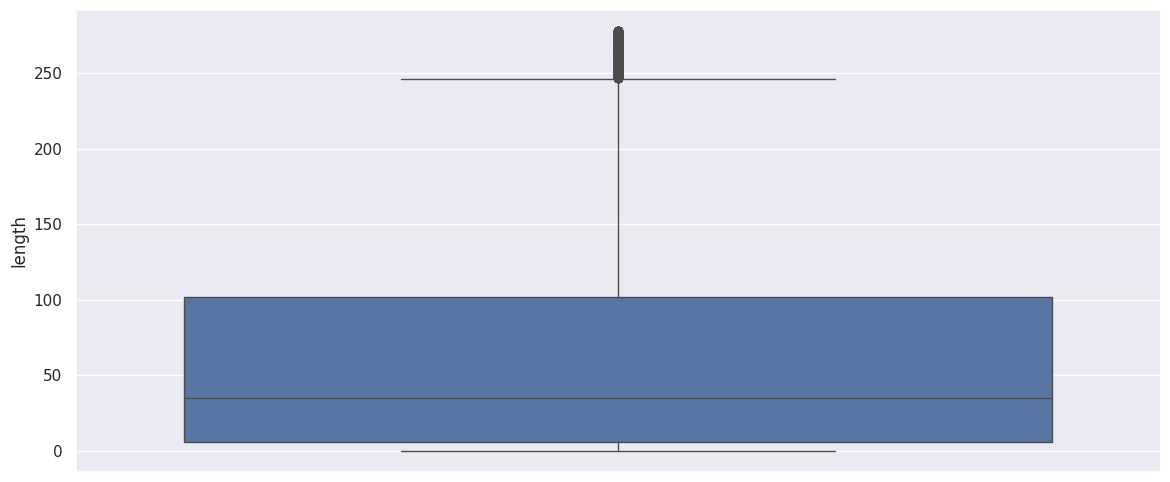

In [62]:
boxplot(cleaned_numeric_data["length"])

In [63]:
cleaned_numeric_data2   = remove_outliers(cleaned_numeric_data, "length")

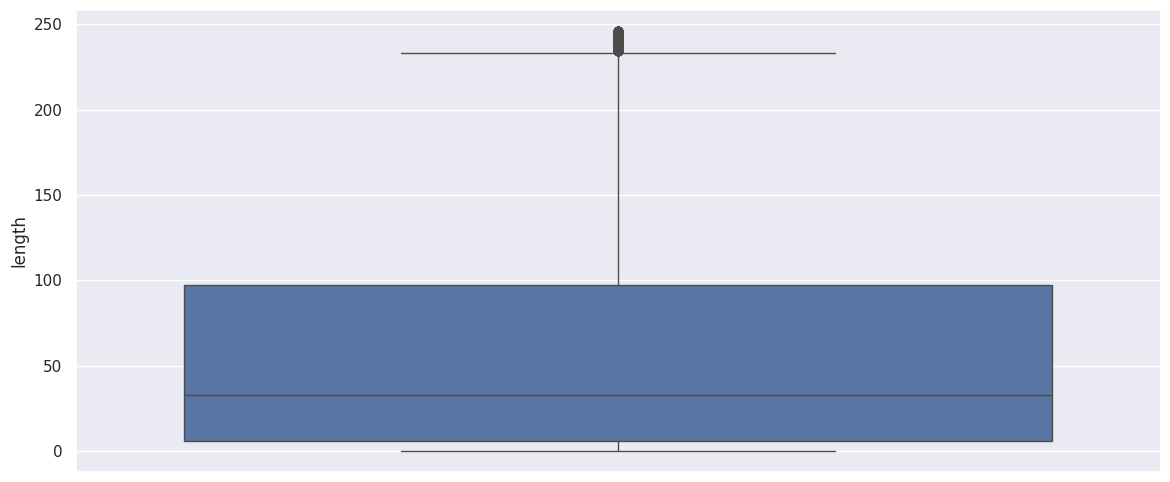

In [64]:
boxplot(cleaned_numeric_data2["length"])

In [65]:
cleaned_numeric_data2.describe()

,PRODUCT_LENGTH,length
count,1.207300e+04,12073.000000
mean,1.571984e+03,59.468069
std,3.694410e+04,64.713630
min,1.000000e+00,0.000000
25%,5.078730e+02,6.000000
50%,6.450000e+02,33.000000
75%,1.000000e+03,97.000000
max,3.996600e+06,246.000000


In [71]:
def padding(sentences, seq_length=max(cleaned_numeric_data2["length"])):
  features = np.zeros((len(sentences), seq_length), dtype=int)

  for i, row in enumerate(sentences):
    if len(row) > 0:
      features[i, -len(row):] = np.array(row)[:seq_length]

  return features

In [72]:
padded_trained_data = padding(cleaned_numeric_data2["inputs"])

In [74]:
padded_trained_data[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0, 5123, 5742,  338, 1327,
        219,  202,  329,   49, 2530,  698,   26,  194,   27,  255, 7501,
        201,  149,   17,   32,  263,  863, 2721,  127,  557,    9,  219,
        901,   31,  125,  164, 7039, 4258,  357,  2

In [75]:
def np_label(label_data):
  labels = np.array(label_data)

  return labels

In [76]:
cleaned_numeric_data2.columns

Index(['PRODUCT_LENGTH', 'inputs', 'length'], dtype='object')

In [77]:
train_np_labels = np_label(cleaned_numeric_data2['PRODUCT_LENGTH'])

In [78]:
def tensor_dataset(data, labels):
  tensor_data = torch.from_numpy(data)
  tensor_labels = torch.from_numpy(labels)

  tensor_dataset = TensorDataset(tensor_data, tensor_labels)

  return tensor_dataset


In [79]:
def dataloader(dataset, batch_size):
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  return dataloader

In [80]:
training_dataset = tensor_dataset(padded_trained_data, train_np_labels)
data_loader      = dataloader(training_dataset, batch_size=64)

**Building A LSTM Model**

In [86]:
class LSTM_Model(nn.Module):
  def __init__(self, input_dim, hidden_dim, embedding_dim, hidden_layers):
    super(LSTM_Model, self).__init__()

    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.embedding_dim = embedding_dim
    self.hidden_layers = hidden_layers
    # self.vocab_size = vocab_size

    # Embedding layer
    self.embedding_layer = nn.Embedding(self.input_dim, self.embedding_dim)

    # LSTM layer | LSTM Unit
    self.lstm = nn.LSTM(self.embedding_dim,
                        self.hidden_dim,
                        self.hidden_layers,
                        batch_first=True,
                        dropout=0.3
                        )

    ## fully connected layer | output layer
    self.output_layer = nn.Linear(self.hidden_dim, 1)

    ## it is for output layer
    self.dropout = nn.Dropout(0.3)

    def forward(inputs, hidden_inputs, batch_size):
      ## passing inputs to the embedding layer
      embed_outputs = self.embedding_layer(inputs)

      ## passing the embedding layer inputs to the lstm layer
      lstm_output, hidden_outputs   = self.lstm(embed_outputs, hidden_inputs)

      ## need to reshape as fully connected layer assumes 2-d data
      lstm_output_cont  = lstm_output.contigious().view(-1, self.hidden_dim)

      ## dropping the units to decrease complexity and overfitting
      output = self.dropout(lstm_output_cont)

      ## passing the lstm outputs to the output layer
      output = self.output_layer(output)

      ## Reshape to original
      output = output.view(batch_size, -1)

      return output, hidden_outputs

In [87]:
input_dim = len(clenaed_vocabulary_)
hidden_dim = 512
embedding_dim = 256
hidden_layers = 3

model = LSTM_Model(input_dim, hidden_dim, embedding_dim, hidden_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()